In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.feature import local_binary_pattern, hog
from skimage import io
import cv2 
import seaborn as sns
import umap 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Loading the data

In [2]:
labels = pd.read_csv('label.csv')

## (1) Performing EDA

#### Class distribution

In [3]:
class_distribution = labels['label'].value_counts()
print(class_distribution)

label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64


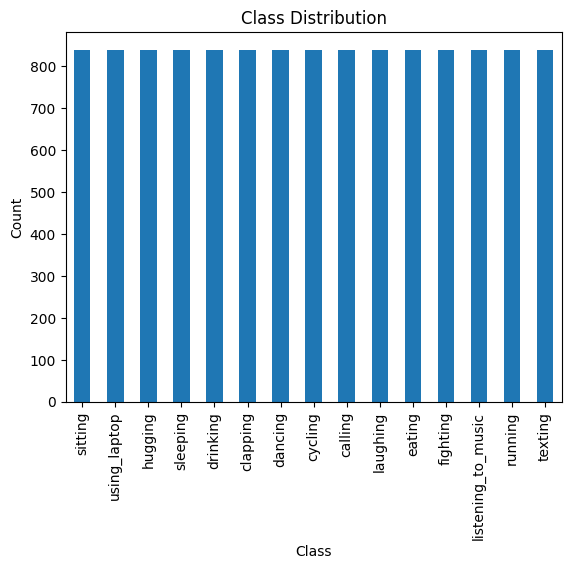

In [4]:
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

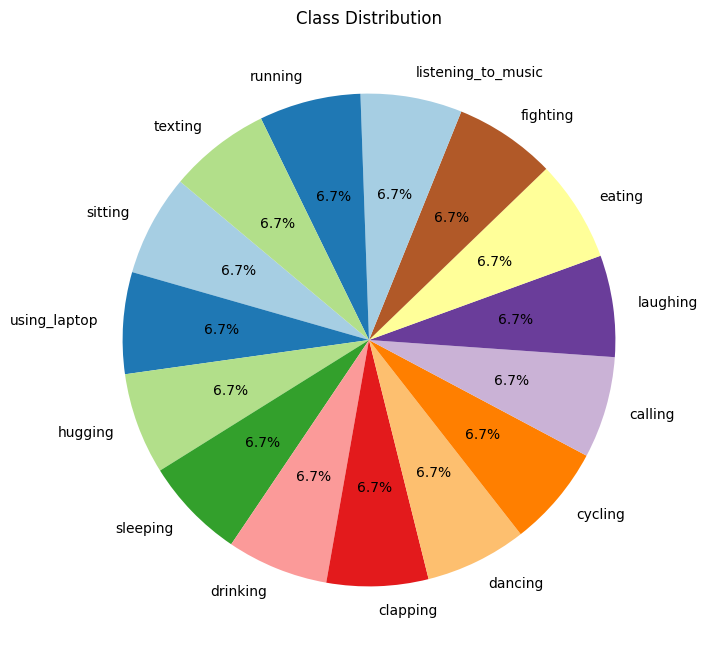

In [5]:
plt.figure(figsize = (8,8))
class_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Class Distribution')
plt.ylabel('')
plt.show()

We notice that the dataset is perfectly balanced, wit 6.7% of the data for each class i.e. 840 samples for each class. If the dataset had been imbalanced, we could have tried to balance it using: Data Augmentation, Under-sampling, Over-sampling, etc.

#### Overview of the dataset

In [6]:
heights = []
widths = []

In [7]:
aspect_ratios = []

In [8]:
avg_reds = []
avg_greens = []
avg_blues = []

##### 10 random samples from the dataset

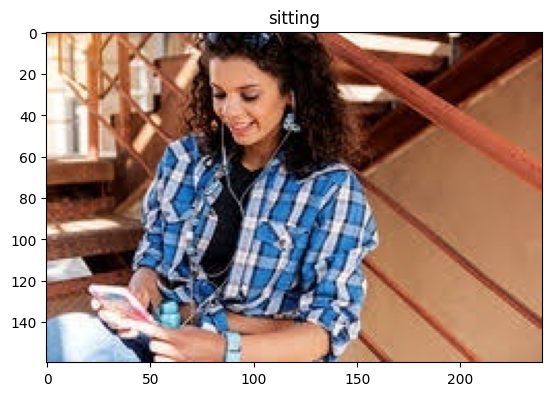

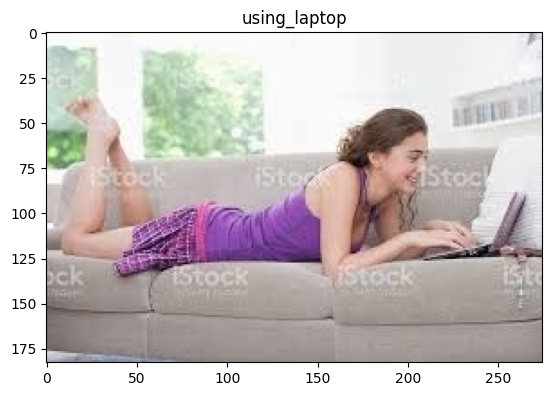

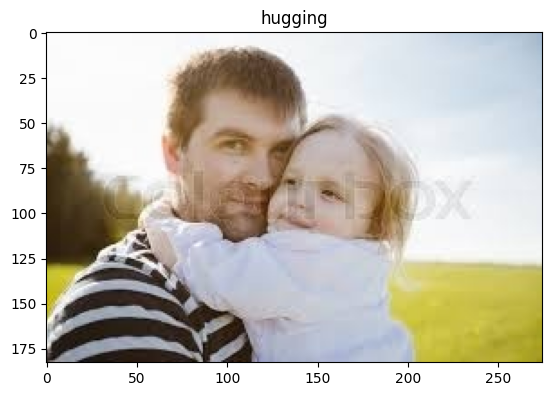

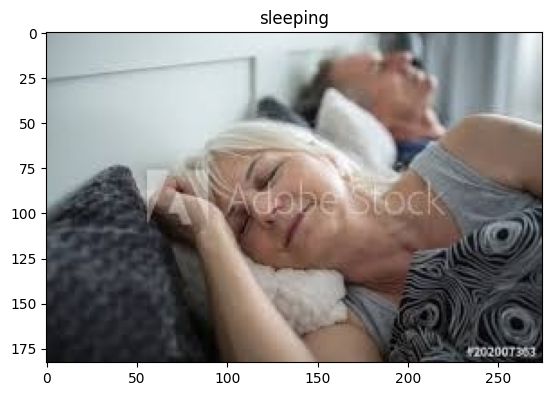

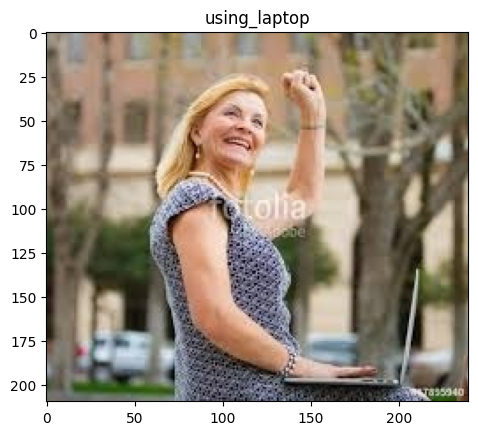

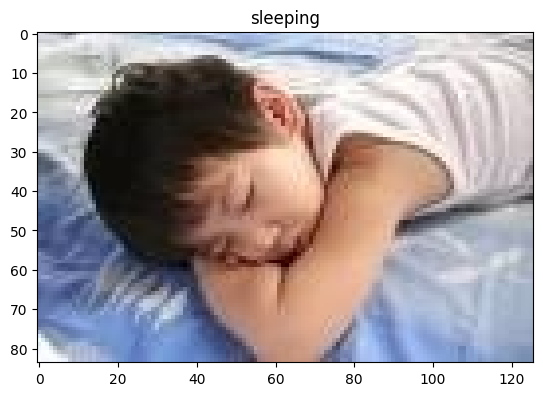

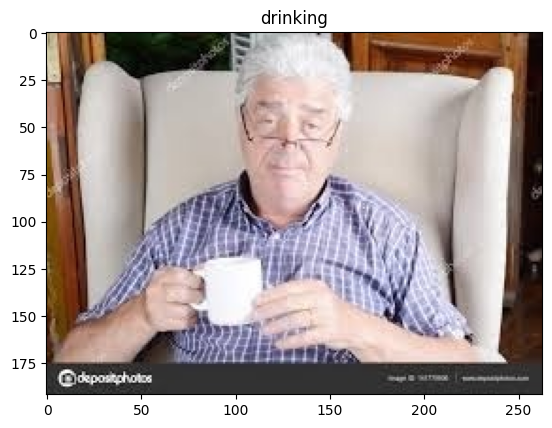

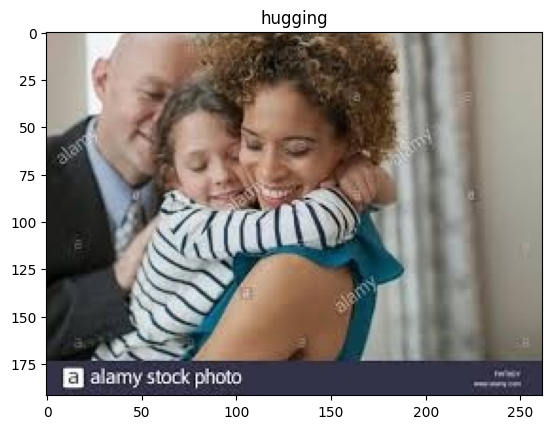

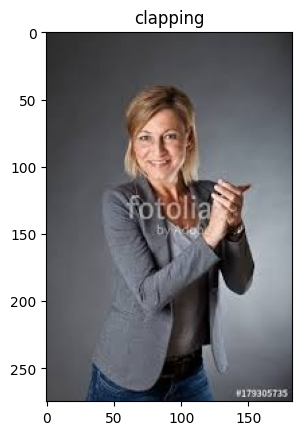

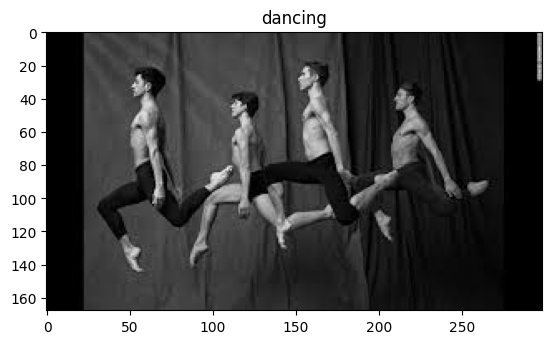

In [9]:
for i in range(10):
    img_path = f'data/{labels.iloc[i, 0]}'
    img = plt.imread(img_path)

    plt.imshow(img)
    plt.title(labels.iloc[i, 1])
    plt.show()

In [10]:
for i in range(len(labels)):
    img_path = f'data/{labels.iloc[i, 0]}'
    img = plt.imread(img_path)

    heights.append(img.shape[0])
    widths.append(img.shape[1])

    aspect_ratios.append(img.shape[1] / img.shape[0])

    if len(img.shape) == 3:
        avg_reds.append(np.mean(img[:, :, 0]))
        avg_greens.append(np.mean(img[:, :, 1]))
        avg_blues.append(np.mean(img[:, :, 2]))

##### Height and Width distribution of the images

Height: min=84, max=318, mean=196.57357142857143


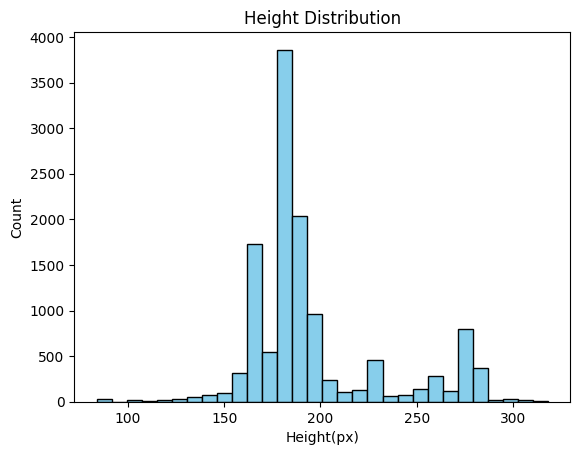

Width: min=84, max=478, mean=260.38103174603174


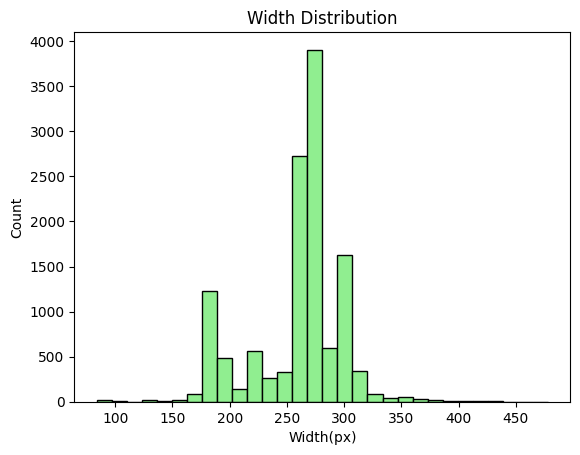

Mean Height: 196.57357142857143
Mean Width: 260.38103174603174
Median Height: 183.0
Median Width: 275.0
Standard Deviation Height: 35.28000220378205
Standard Deviation Width: 39.91769674243761


In [11]:
heights = np.array(heights)
widths = np.array(widths)

print(f'Height: min={heights.min()}, max={heights.max()}, mean={heights.mean()}')

plt.hist(heights, bins = 30, color = 'skyblue', edgecolor = 'black')
plt.title('Height Distribution')
plt.xlabel('Height(px)')
plt.ylabel('Count')
plt.show()

print(f'Width: min={widths.min()}, max={widths.max()}, mean={widths.mean()}')

plt.hist(widths, bins = 30, color = 'lightgreen', edgecolor = 'black')
plt.title('Width Distribution')
plt.xlabel('Width(px)')
plt.ylabel('Count')
plt.show()

print(f'Mean Height: {heights.mean()}')
print(f'Mean Width: {widths.mean()}')
print(f'Median Height: {np.median(heights)}')
print(f'Median Width: {np.median(widths)}')
print(f'Standard Deviation Height: {heights.std()}')
print(f'Standard Deviation Width: {widths.std()}')

##### Aspect ratio and Average Color distribution

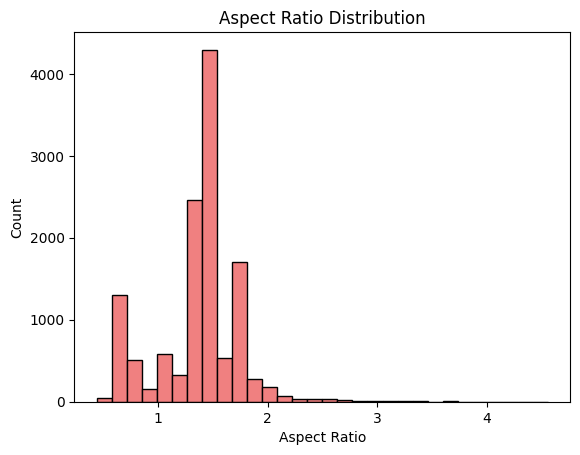

Mean Aspect Ratio: 1.3885972364078982
Median Aspect Ratio: 1.5027322404371584
Standard Deviation Aspect Ratio: 0.38493922580948603
Mean Red: min=8.670660705414804, max=252.31279012345678, mean=146.08027162791456, median=146.32192950566372, std=44.1388205120611
Mean Green: min=8.670660705414804, max=250.54587654320989, mean=137.15848065890677, median=137.0966773265954, std=43.737389863150405
Mean Blue: min=5.201289682539683, max=250.1002074074074, mean=129.25501046516612, median=126.94373460852788, std=45.65596232414242


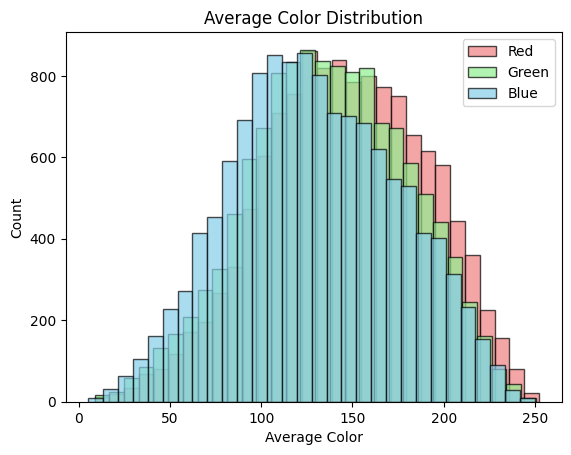

In [12]:
aspect_ratios = np.array(aspect_ratios)

plt.hist(aspect_ratios, bins = 30, color = 'lightcoral', edgecolor = 'black')
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio')
plt.ylabel('Count')
plt.show()

print(f'Mean Aspect Ratio: {np.mean(aspect_ratios)}')
print(f'Median Aspect Ratio: {np.median(aspect_ratios)}')
print(f'Standard Deviation Aspect Ratio: {np.std(aspect_ratios)}')

avg_reds = np.array(avg_reds)
avg_greens = np.array(avg_greens)
avg_blues = np.array(avg_blues)

print(f'Mean Red: min={avg_reds.min()}, max={avg_reds.max()}, mean={avg_reds.mean()}, median={np.median(avg_reds)}, std={avg_reds.std()}')
print(f'Mean Green: min={avg_greens.min()}, max={avg_greens.max()}, mean={avg_greens.mean()}, median={np.median(avg_greens)}, std={avg_greens.std()}')
print(f'Mean Blue: min={avg_blues.min()}, max={avg_blues.max()}, mean={avg_blues.mean()}, median={np.median(avg_blues)}, std={avg_blues.std()}')

plt.hist(avg_reds, bins = 30, color = 'lightcoral', edgecolor = 'black', alpha = 0.7, label = 'Red')
plt.hist(avg_greens, bins = 30, color = 'lightgreen', edgecolor = 'black', alpha = 0.7, label = 'Green')
plt.hist(avg_blues, bins = 30, color = 'skyblue', edgecolor = 'black', alpha = 0.7, label = 'Blue')
plt.title('Average Color Distribution')
plt.xlabel('Average Color')
plt.ylabel('Count')
plt.legend()
plt.show()

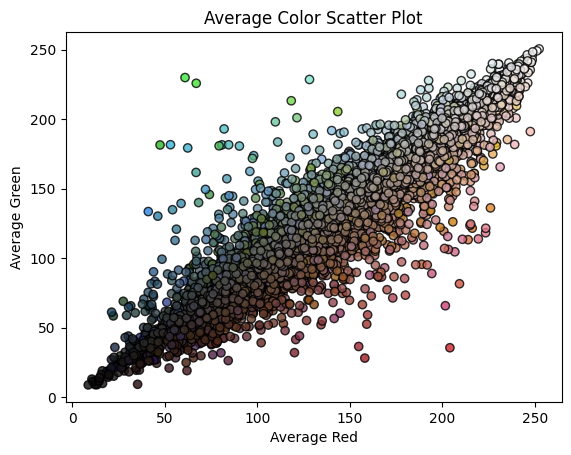

In [13]:
plt.scatter(avg_reds, avg_greens, c=np.stack((avg_reds, avg_greens, avg_blues), axis=-1)/255, alpha=0.8, edgecolor='black')

plt.title('Average Color Scatter Plot')
plt.xlabel('Average Red')
plt.ylabel('Average Green')
plt.show()

## (2) Feature Extraction
We are extracting the following features: SIFT, HOG, LBP and Color Histograms. We are using these features because they are known to be effective in image classification tasks.
We will perform binning on the extracted features to reduce the dimensionality of the data and prevent memory errors (which we were facing with the raw features).

SIFT (Scale-Invariant Feature Transform) is a feature detection algorithm to detect and describe local features in images. It is invariant to image scaling and rotation, and partially invariant to change in illumination and 3D camera viewpoint.\
HOG (Histogram of Oriented Gradients) is a feature descriptor used in computer vision and image processing for the purpose of object detection.\
LBP (Local Binary Patterns) is a type of visual descriptor used for classification in computer vision.\
Color Histograms are used to represent the distribution of colors in an image.

For my extracted features the best results were obtained when binning was 8. Increasing the binning to 8 or 16 or varying it slightly across the features resulted in best accuracy of around 29.88%

In [28]:
def reduce_sift_bins(descriptors, new_bins=8):
    bin_factor = len(descriptors) // new_bins
    reduced_sift = np.add.reduceat(descriptors, np.arange(0, len(descriptors), bin_factor))
    return reduced_sift

In [29]:
def reduce_color_bins(hist, new_bins=8):
    bin_factor = 256 // new_bins  
    reduced_hist = np.add.reduceat(hist, np.arange(0, len(hist), bin_factor))
    return reduced_hist

In [30]:
def reduce_lbp_bins(lbp_hist, new_bins=8):
    if new_bins >= len(lbp_hist):
        return lbp_hist  
    
    bin_factor = len(lbp_hist) // new_bins
    reduced_lbp = np.add.reduceat(lbp_hist, np.arange(0, len(lbp_hist), bin_factor))
    return reduced_lbp

In [31]:
def reduce_hog_bins(hog_features, new_bins=8):
    bin_factor = len(hog_features) // new_bins
    reduced_hog = np.add.reduceat(hog_features, np.arange(0, len(hog_features), bin_factor))
    return reduced_hog

In [32]:
def extract_features(img_path):
    features = {}

    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))  
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # SIFT
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray_img, None)
    if descriptors is not None:
        sift_descriptors = descriptors.flatten()
        features['sift'] = reduce_sift_bins(sift_descriptors)
    else:
        features['sift'] = np.zeros(32) 

    # Color histogram with reduced bins
    hist_b = reduce_color_bins(cv2.calcHist([img], [0], None, [256], [0, 256]))
    hist_g = reduce_color_bins(cv2.calcHist([img], [1], None, [256], [0, 256]))
    hist_r = reduce_color_bins(cv2.calcHist([img], [2], None, [256], [0, 256]))

    hist_b /= np.sum(hist_b) if np.sum(hist_b) != 0 else 1
    hist_g /= np.sum(hist_g) if np.sum(hist_g) != 0 else 1
    hist_r /= np.sum(hist_r) if np.sum(hist_r) != 0 else 1

    features['color_histogram'] = [hist_b, hist_g, hist_r]

    # LBP
    lbp = local_binary_pattern(gray_img, 8, 1, 'uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
    lbp_hist = lbp_hist.astype(float) / (lbp_hist.sum() + 1e-6)
    features['lbp'] = reduce_lbp_bins(lbp_hist)

    # HOG
    hog_features = hog(gray_img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)
    features['hog'] = reduce_hog_bins(hog_features)

    return features


In [33]:
img_folder = 'data'
features = []

for i in range(len(labels)):
    img_path = os.path.join(img_folder, labels.iloc[i, 0])
    features.append(extract_features(img_path))

In [34]:
print("no. of features extracted: ", len(features))
print("no. of features extracted for each image: ", len(features[0]))
# print(features)

no. of features extracted:  12600
no. of features extracted for each image:  4


In [35]:
print(features[0]['sift'].shape)
print(features[0]['color_histogram'][0].shape)
print(features[0]['color_histogram'][1].shape)
print(features[0]['color_histogram'][2].shape)
print(features[0]['lbp'].shape)
print(features[0]['hog'].shape)

(8,)
(8, 1)
(8, 1)
(8, 1)
(9,)
(9,)


In [36]:
feature_list = []
for i in features:
    combined = np.hstack([i['sift'], i['color_histogram'][0].flatten(), i['color_histogram'][1].flatten(), i['color_histogram'][2].flatten(), i['lbp'], i['hog']])
    feature_list.append(combined)

In [37]:
print(feature_list[0].shape)
# print(feature_list[0])

(50,)


In [38]:
# print(feature_list[0])

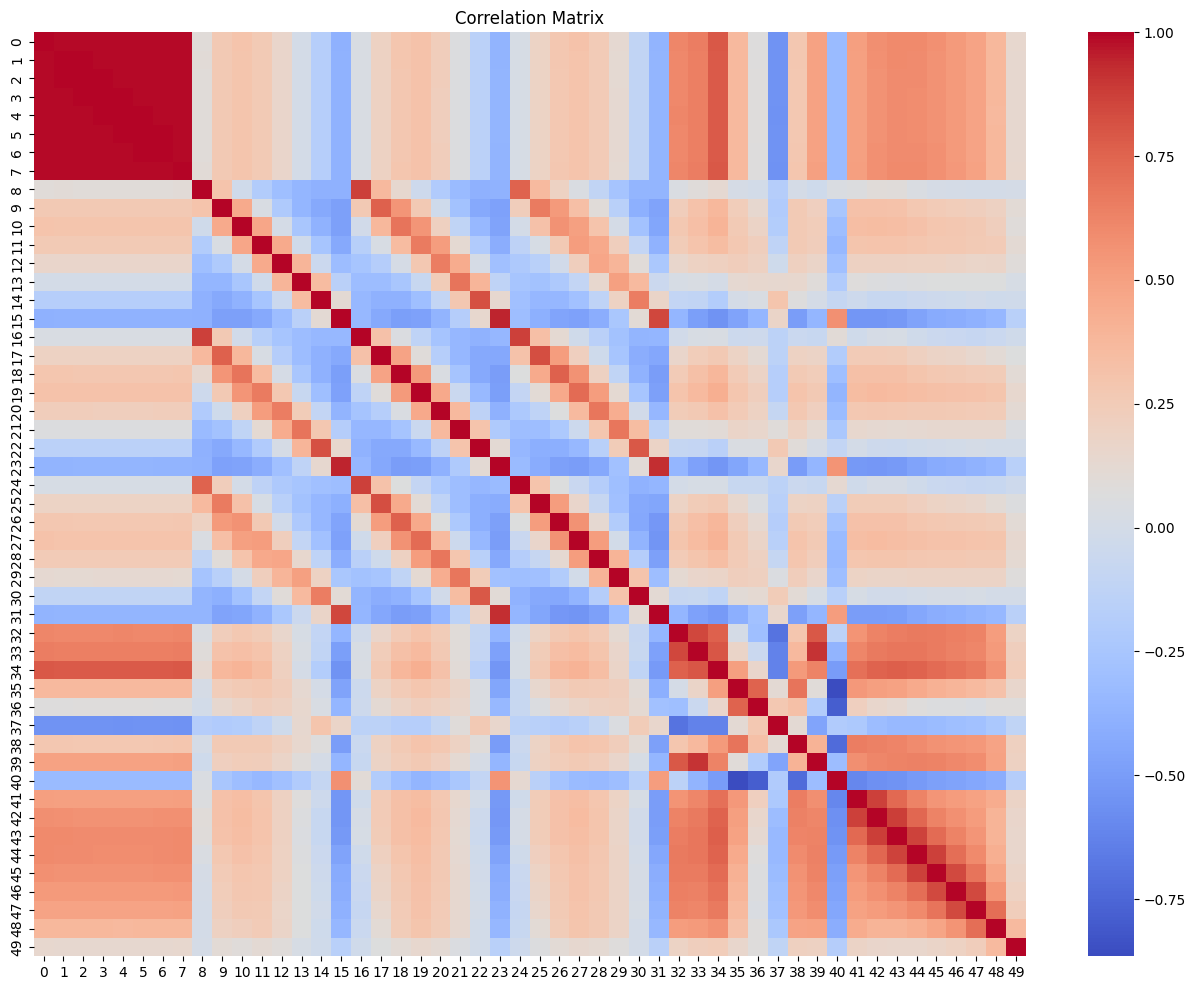

In [39]:
df_features = pd.DataFrame(feature_list)

corr_matrix = df_features.corr()

plt.figure(figsize=(16,12))  
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')  # Save the figure
plt.show()

From the above correlation matrix we can observe that features 0-7 all have a highly positive correlation with all features 0-7. Similarly, features 7-31 seem to also have correlations with each other (both positive and negative). Given, the heatmap, it seems that we have chosen appropriate features with not too high of a correlation with each other.

In [40]:
print(df_features.head())

         0         1         2         3         4         5         6   \
0   90316.0  100405.0  102866.0  101792.0   96516.0   98304.0   96950.0   
1   27590.0   28243.0   29716.0   31651.0   29811.0   28081.0   26216.0   
2   41103.0   44295.0   45675.0   46283.0   47759.0   45378.0   45144.0   
3   51811.0   50335.0   48994.0   51602.0   50489.0   50175.0   56211.0   
4  103939.0  111915.0  106367.0  110161.0  107363.0  104932.0  106317.0   

         7         8         9   ...        40          41          42  \
0   75810.0  0.180481  0.144348  ...  0.225891  130.728963  132.117393   
1   28266.0  0.002014  0.013062  ...  0.275085  109.515815  120.993655   
2   42223.0  0.061157  0.096558  ...  0.235718  105.140167  108.586859   
3   50671.0  0.047546  0.174988  ...  0.160645  113.777331  110.377107   
4  103129.0  0.048950  0.117493  ...  0.146301  136.100860  135.827105   

           43          44          45          46          47          48  \
0  133.384722  133.184732  

##### Creating a CSV file with the extracted features

In [41]:
if 'label' not in df_features.columns:
    df_features['label'] = labels.iloc[:, 1]  # Assuming class labels are in the second column
if 'image' not in df_features.columns:
    df_features['image'] = labels.iloc[:, 0]  # Assuming image file names are in the first column

# Reorder the DataFrame to have 'image' and 'label' at the beginning
df_features = df_features[['image', 'label'] + [col for col in df_features.columns if col not in ['image', 'label']]]

# Save the DataFrame to a CSV file
df_features.to_csv('image_features.csv', index=False)

# Print the column names to verify
print("Columns in df_features:", df_features.columns)
print("Features successfully saved to 'image_features.csv'")

Columns in df_features: Index(['image', 'label',       0,       1,       2,       3,       4,       5,
             6,       7,       8,       9,      10,      11,      12,      13,
            14,      15,      16,      17,      18,      19,      20,      21,
            22,      23,      24,      25,      26,      27,      28,      29,
            30,      31,      32,      33,      34,      35,      36,      37,
            38,      39,      40,      41,      42,      43,      44,      45,
            46,      47,      48,      49],
      dtype='object')
Features successfully saved to 'image_features.csv'
